In [1]:
# Mount the code from google drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Install required packages for the code  
!pip install keras==2.2.4
!pip install tensorflow==2.0


     |████████████████████████████████| 317kB 5.2MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 450kB 52.5MB/s 
     |████████████████████████████████| 3.8MB 49.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a548dfdf6a024e25f26d9fab7507225f04f28ab8ae5731e0f624c6c60d81e4d5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    U

In [ ]:
# import tensorflow library and check the version 

import tensorflow
print(tensorflow.__version__)

2.0.0


In [ ]:
# Import preprocessing methods
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from imutils import paths
import os

data = []
labels = []

DATA_PATH = "/content/drive/My Drive/Face_Mask_Detection/Dataset"  # path of the dataset
image_path_list = list(paths.list_images(DATA_PATH))

for image_path in image_path_list:
    # extract the class label from the filename
    label = image_path.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) # this function adds channels: x.shape = (224, 224, 3) for RGB and (224, 224, 1) for gray image
    image = preprocess_input(image)
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
import numpy as np

data = np.array(data, dtype="float32")  # converts data array to float32
labels = np.array(labels) # converts labels to array

In [ ]:
# Below process converts multiclass labels to binary labels and categorizes it

from sklearn.preprocessing import LabelBinarizer 
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# split the data into train and test 
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.20
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=TEST_SIZE, stratify=labels, random_state=42)

In [ ]:
# Apply series of transformation on image like rotate,resize ,sear etc.


from tensorflow.keras.preprocessing.image import ImageDataGenerator 

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
# get the pretrained model as the base model . 
# MobileNet model has been processed on ImageNet dataset and then our training dataset

# Include_top is false because we have not include fully connected layer at the top of network
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
 
baseModel = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [ ]:
# add layers on the base MobileNet model like Averagepooling,Flatten , Dense,Dropout

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel) 
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel) 
headModel = Dense(2, activation="softmax")(headModel) 

In [ ]:
# Placing the FC headModel on top of base model 
from tensorflow.keras.models import Model

model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
#not be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

#setting the variables
INIT_LR = 1e-4 # learning rate
EPOCHS = 1 #How many times it sould run
BATCH_SIZE = 32 # number of training samples in one epoch

In [ ]:
# compile the model 
from tensorflow.keras.optimizers import Adam 

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS) 
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"]) 

In [ ]:
# train the head of the network for a 20 epochs 
# So that the new FC layers will start to become
# initialized with actual "learned" values versus pure random

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE), 
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=20)


Train for 95 steps, validate on 767 samples
Epoch 1/20
95/95 [==============================] - 325s 3s/step - loss: 0.5288 - accuracy: 0.7343 - val_loss: 0.5086 - val_accuracy: 0.7473
Epoch 2/20
95/95 [==============================] - 323s 3s/step - loss: 0.2979 - accuracy: 0.8810 - val_loss: 0.4048 - val_accuracy: 0.8247
Epoch 3/20
95/95 [==============================] - 325s 3s/step - loss: 0.2284 - accuracy: 0.9113 - val_loss: 0.4146 - val_accuracy: 0.8370
Epoch 4/20
95/95 [==============================] - 344s 4s/step - loss: 0.1977 - accuracy: 0.9232 - val_loss: 0.2755 - val_accuracy: 0.8859
Epoch 5/20
95/95 [==============================] - 359s 4s/step - loss: 0.1750 - accuracy: 0.9370 - val_loss: 0.2597 - val_accuracy: 0.8940
Epoch 6/20
95/95 [==============================] - 363s 4s/step - loss: 0.1510 - accuracy: 0.9525 - val_loss: 0.2317 - val_accuracy: 0.9090
Epoch 7/20
95/95 [==============================] - 356s 4s/step - loss: 0.1433 - accuracy: 0.9506 - val_loss:

In [ ]:
# save the model 
model.save("mobile_net_model_tensorflow.h5",save_format="h5")


{'loss': [0.5291889481388902, 0.29806116544540256, 0.22847757983066255, 0.19769758532215437, 0.17511183877052566, 0.1511769289434467, 0.14345781051295323, 0.12958936500329285, 0.12904108945837756, 0.12643429096211078, 0.11414726967717678, 0.12124130541879878, 0.10606090203124045, 0.10195670142308143, 0.10287610495471608, 0.09480275168533614, 0.09475101942126501, 0.09341892789639214, 0.09544298575359815, 0.08171750730346831], 'accuracy': [0.7343441, 0.8810152, 0.91133815, 0.9232037, 0.9370468, 0.9525379, 0.95056033, 0.9545155, 0.9525379, 0.9531971, 0.95748186, 0.9564931, 0.96143705, 0.9624258, 0.96407384, 0.9690178, 0.966381, 0.96572185, 0.9667106, 0.9703362], 'val_loss': [0.5085798721114535, 0.40475051126393063, 0.41463129088340867, 0.27554595423801626, 0.25973315873077674, 0.2317139817962746, 0.2922012569696061, 0.21448062078582883, 0.18628412368555577, 0.25371099917176804, 0.21770398853033432, 0.22377562041077495, 0.15612758589226078, 0.2034137792972729, 0.18572730198988238, 0.307305

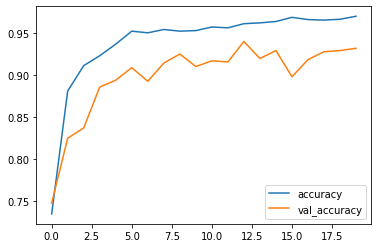

In [ ]:
# get th egraph of Accuray vs. Val_accuracy
import pandas as pd
print(H.history)  
history_df = pd.DataFrame(H.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
# load the model
from tensorflow.keras.models import load_model

model = load_model("mobile_net_model_tensorflow.h5")

In [ ]:
#CNN_Model
# import all the libraries for CNN model and layers and optimizer
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# add the layers in model
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224, 224,3)))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
# add activators 
model.add(Dense(100,activation='relu'))
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [ ]:
# Rescale the so that its resolution comes between 0 to 1
test_datagen = ImageDataGenerator(rescale=1./255) 

In [ ]:
INIT_LR = 1e-4
EPOCHS = 1
BATCH_SIZE = 32

In [ ]:
# fit the CNN model
History=model.fit(
    train_datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=20)

model.save('cnn_tensorflow.h5')

Train for 95 steps, validate on 767 samples
Epoch 1/20
95/95 [==============================] - 184s 2s/step - loss: 0.4876 - accuracy: 0.7399 - val_loss: 8.8175 - val_accuracy: 0.8947
Epoch 2/20
95/95 [==============================] - 182s 2s/step - loss: 0.2516 - accuracy: 0.9044 - val_loss: 8.4837 - val_accuracy: 0.9287
Epoch 3/20
95/95 [==============================] - 181s 2s/step - loss: 0.2247 - accuracy: 0.9194 - val_loss: 10.2096 - val_accuracy: 0.9151
Epoch 4/20
95/95 [==============================] - 180s 2s/step - loss: 0.2286 - accuracy: 0.9164 - val_loss: 10.3834 - val_accuracy: 0.9110
Epoch 5/20
95/95 [==============================] - 180s 2s/step - loss: 0.2042 - accuracy: 0.9278 - val_loss: 10.5662 - val_accuracy: 0.9035
Epoch 6/20
95/95 [==============================] - 179s 2s/step - loss: 0.1983 - accuracy: 0.9273 - val_loss: 12.3824 - val_accuracy: 0.9185
Epoch 7/20
95/95 [==============================] - 179s 2s/step - loss: 0.1960 - accuracy: 0.9277 - val_l

{'loss': [0.4880499522506837, 0.25159560617405724, 0.2248992214547857, 0.22870891361976817, 0.2043754472179325, 0.19852343824892824, 0.19623796341249483, 0.18874051312356696, 0.18094619029571762, 0.17043639060377525, 0.17755021321376688, 0.1533990926210552, 0.1683248755428142, 0.15483929271623736, 0.14991680029767393, 0.16343679815904041, 0.13472572088379095, 0.13527277318040007, 0.13434592223356018, 0.12289193196709641], 'accuracy': [0.73994726, 0.9044166, 0.9194133, 0.9164469, 0.92781806, 0.92732364, 0.92765325, 0.9297956, 0.93144363, 0.9403428, 0.9340804, 0.9444628, 0.9370468, 0.9414964, 0.94429797, 0.9380356, 0.9518787, 0.94924194, 0.9522083, 0.9535267], 'val_loss': [8.817491892732662, 8.483692109507189, 10.209629824761462, 10.38336961987432, 10.566212978636582, 12.382384828669462, 12.542932806300993, 16.17946478534087, 14.581110234366246, 11.575657406251153, 10.129575568798934, 15.340430417614158, 15.471270893201368, 12.132280944118621, 10.27230351782529, 14.041720529578654, 21.93

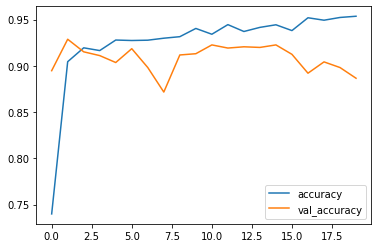

In [ ]:
# get the graph of accuracy vs. val_accuracy of trained CNN model 

import pandas as pd
print(History.history)  
history_df = pd.DataFrame(History.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
# load the model
from tensorflow.keras.models import load_model

model = load_model("cnn_tensorflow.h5")